#run this worksheet first, downloads and splits files into required directories.  
Kaggle-cats-dogs-redux-1_load_data

brief summary of model build and train process.
-----------------------------
vgg = Vgg16()  
model = vgg.model  
model.pop()  
set all layers to non trainable  
model.add(Dense(2, activation='softmax'))  
model.compile(optimizer=RMSprop(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])  
fit model, 2 epochs. NB: only the last layer is trainable during these epochs.  
locate first Dense layer, set all subsequent layers to trainable.  
set new (lower) learning rate.  
K.set_value(opt.lr, 0.01)    
fit model, 3 epochs  
make layers from 12th layer onwards trainable.   
(NB: 12 layer is a Convolution2D layer, not the first or last Convolution2D)  
K.set_value(opt.lr, 0.001)  
fit model, 4 epochs  

at end still seeing some overfitting.  
loss: 0.4689 - acc: 0.9706 - val_loss: 0.3814 - val_acc: 0.9747  


In [1]:
sample_or_prod = False #True = sample, False = production

batch_size = 64 #ajust to suit memory capacity of hardware.

In [2]:
HOMEPATH = "/home/ubuntu/fastai/"

DATA_PATH = HOMEPATH+"data/Kaggle_dogs-vs-cats-redux-kernels-edition/"

MODEL_PATH = DATA_PATH+"models/"
RESULTS_PATH = DATA_PATH+"results/"


SAMPLE_DATA_PATH = DATA_PATH + "sample/"#choose this for testing or above for production
SAMPLE_TEST_PATH = SAMPLE_DATA_PATH+"test/"
SAMPLE_TRAIN_PATH = SAMPLE_DATA_PATH + "train/"
SAMPLE_VALID_PATH = SAMPLE_DATA_PATH + "valid/"


TEST_PATH = DATA_PATH+"test/"
TRAIN_PATH = DATA_PATH + "train/"
VALID_PATH = DATA_PATH + "valid/"


if sample_or_prod:
    WORKING_DATA  = SAMPLE_DATA_PATH
    WORKING_TEST  = SAMPLE_TEST_PATH
    WORKING_TRAIN = SAMPLE_TRAIN_PATH
    WORKING_VALID = SAMPLE_VALID_PATH
    s_or_p = "_sample_"
else:
    WORKING_DATA  = DATA_PATH
    WORKING_TEST  = TEST_PATH
    WORKING_TRAIN = TRAIN_PATH
    WORKING_VALID = VALID_PATH
    s_or_p = "_prod_"

    
print ("WORKING_DATA:", WORKING_DATA)
print ("WORKING_TEST:", WORKING_TEST)
print ("WORKING_TRAIN:", WORKING_TRAIN)
print ("WORKING_VALID:", WORKING_VALID)
print ("s_or_p:", s_or_p)


('WORKING_DATA:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/')
('WORKING_TEST:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/test/')
('WORKING_TRAIN:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/')
('WORKING_VALID:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/')
('s_or_p:', '_prod_')


In [3]:
import os
from datetime import datetime
from glob import glob
from random import shuffle
from shutil import copyfile


In [4]:
os.chdir(HOMEPATH)
print ("os.getcwd:", os.getcwd())
# Rather than importing everything manually, we'll make things easy
#   and load them all in utils.py, and just import them from there.
%matplotlib inline
import utils; reload(utils)
from utils import *

('os.getcwd:', '/home/ubuntu/fastai')


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5110)
Using Theano backend.


In [5]:
os.chdir(DATA_PATH)
print (os.getcwd())
!tree -d

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition
.
├── models
│   ├── train_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── train_data_sample_.bc
│   │   ├── data
│   │   └── meta
│   ├── valid_convlayer_features_sample_.bc
│   │   ├── data
│   │   └── meta
│   └── valid_data_sample_.bc
│       ├── data
│       └── meta
├── results
├── sample
│   ├── test
│   │   └── unknown
│   ├── train
│   │   ├── cat
│   │   └── dog
│   └── valid
│       ├── cat
│       └── dog
├── test
│   └── unknown
├── train
│   ├── cat
│   └── dog
└── valid
    ├── cat
    └── dog

31 directories


In [6]:
CATEGORIES = ['cat/', 'dog/']#nb: do not change order or trailing slash
UNKNOWN = 'unknown/'


In [7]:
DATA_DIR_LIST = [DATA_PATH, SAMPLE_DATA_PATH, SAMPLE_TEST_PATH, SAMPLE_TEST_PATH+UNKNOWN, SAMPLE_TRAIN_PATH, 
                 SAMPLE_VALID_PATH, TEST_PATH, TEST_PATH+UNKNOWN, TRAIN_PATH, VALID_PATH, MODEL_PATH, RESULTS_PATH]



for category in CATEGORIES:
    DATA_DIR_LIST.append(TRAIN_PATH+category)
    DATA_DIR_LIST.append(VALID_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_TRAIN_PATH+category)
    DATA_DIR_LIST.append(SAMPLE_VALID_PATH+category)


#delete the variables we don't need to prevent accidental use.
del SAMPLE_DATA_PATH
del SAMPLE_TEST_PATH
del SAMPLE_TRAIN_PATH
del SAMPLE_VALID_PATH
del TEST_PATH
del TRAIN_PATH
del VALID_PATH


In [8]:
def dirFileList(dir_path):
    return [name for name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, name))]

In [9]:
def listDirsFileCount(DATA_DIR_LIST):
    DATA_DIR_LIST = sorted(DATA_DIR_LIST)
    for dir_ in DATA_DIR_LIST:
        print dir_, len(dirFileList(dir_))


In [10]:
def showLayersInfo(model):
    print ("Number of layers : ", len(model.layers))
    count = 0
    for layer in model.layers:
        print count, type(layer), ", trainable:", layer.trainable
        print "input:", layer.input_shape, ", output:",layer.output_shape, "\n"
        count +=1

In [11]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [12]:
def onehot(x): 
    return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

In [13]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show()

In [14]:
listDirsFileCount(DATA_DIR_LIST)

/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/ 3
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/ 7
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/results/ 1
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/test/unknown/ 2500
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/cat/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/train/dog/ 1750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/ 0
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/cat/ 750
/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/sample/valid/dog/ 750

In [15]:
os.chdir(HOMEPATH)
print(os.getcwd())
from vgg16 import Vgg16
vgg = Vgg16()
model = vgg.model
print (type(vgg))
print (type(model))

/home/ubuntu/fastai
<type 'instance'>
<class 'keras.models.Sequential'>


In [16]:
showLayersInfo(model)

('Number of layers : ', 38)
0 <class 'keras.layers.core.Lambda'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: True
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: True
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: True
input

In [17]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [19]:
print ("before pop, # of layers:", len(model.layers))
model.pop()
print ("after pop, # of layers:", len(model.layers))

('before pop, # of layers:', 38)
('after pop, # of layers:', 37)


In [20]:
for layer in model.layers: 
    layer.trainable=False

In [21]:
showLayersInfo(model)

('Number of layers : ', 37)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [22]:
print ("before adding dense layer, # of layers:", len(model.layers))
if len(model.layers)==37:
    model.add(Dense(2, activation='softmax'))
else:
    print "did not add layer, wrong # of layers."
print ("after adding dense layer, # of layers:", len(model.layers))


('before adding dense layer, # of layers:', 37)
('after adding dense layer, # of layers:', 38)


In [23]:
print "WORKING_TRAIN:", WORKING_TRAIN
print "WORKING_VALID:", WORKING_VALID

WORKING_TRAIN: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/train/
WORKING_VALID: /home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/valid/


In [24]:
#utils.get_data
val_data = get_data(WORKING_VALID)
print (type(val_data), val_data.shape)

Found 7500 images belonging to 2 classes.
(<type 'numpy.ndarray'>, (7500, 3, 224, 224))


In [25]:
trn_data = get_data(WORKING_TRAIN)
print ("trn_data:", type(trn_data), trn_data.shape)

Found 17500 images belonging to 2 classes.
('trn_data:', <type 'numpy.ndarray'>, (17500, 3, 224, 224))


In [26]:
print ("MODEL_PATH:", MODEL_PATH)

('MODEL_PATH:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/')


In [27]:
print ("MODEL_PATH:", MODEL_PATH)
save_array(MODEL_PATH+'train_data'+s_or_p+'.bc', trn_data)
save_array(MODEL_PATH+'valid_data'+s_or_p+'.bc', val_data)

('MODEL_PATH:', '/home/ubuntu/fastai/data/Kaggle_dogs-vs-cats-redux-kernels-edition/models/')


In [28]:
#possibly reuse this code
#trn_data = load_array(model_path+'train_data.bc')
#val_data = load_array(model_path+'valid_data.bc')

In [29]:
# Use batch size of 1 since we're just doing preprocessing on the CPU
val_batches = get_batches(WORKING_VALID, shuffle=False, batch_size=1)
trn_batches = get_batches(WORKING_TRAIN, shuffle=False, batch_size=1)

Found 7500 images belonging to 2 classes.
Found 17500 images belonging to 2 classes.


In [30]:
val_classes = val_batches.classes
trn_classes = trn_batches.classes
print ("val_classes:", type(val_classes), val_classes.shape)
print(val_classes[0:10])
print ("trn_classes:", type(trn_classes), trn_classes.shape)
print(trn_classes[0:10])
val_labels = onehot(val_classes)
trn_labels = onehot(trn_classes)
print ("val_labels:", val_labels[0])
print ("trn_labels:", trn_labels[0])

('val_classes:', <type 'numpy.ndarray'>, (7500,))
[0 0 0 0 0 0 0 0 0 0]
('trn_classes:', <type 'numpy.ndarray'>, (17500,))
[0 0 0 0 0 0 0 0 0 0]
('val_labels:', array([ 1.,  0.]))
('trn_labels:', array([ 1.,  0.]))


In [31]:
gen=image.ImageDataGenerator()
print ("gen:", type(gen))
trn_batches = gen.flow(trn_data, trn_labels, batch_size=batch_size, shuffle=True)
#https://keras.io/preprocessing/image/
#flow(x, y): Takes numpy data & label arrays, 
#and generates batches of augmented/normalized data. 
#Yields batches indefinitely, in an infinite loop.

val_batches = gen.flow(val_data, val_labels, batch_size=batch_size, shuffle=False)

print ("trn_batches:", type(trn_batches))
print ("val_batches:", type(val_batches))

('gen:', <class 'keras.preprocessing.image.ImageDataGenerator'>)
('trn_batches:', <class 'keras.preprocessing.image.NumpyArrayIterator'>)
('val_batches:', <class 'keras.preprocessing.image.NumpyArrayIterator'>)


In [32]:
def fit_model(model, batches, val_batches, nb_epoch=1):
    history = model.fit_generator(batches, 
                        samples_per_epoch=batches.n, 
                        nb_epoch=nb_epoch, 
                        validation_data=val_batches, 
                        nb_val_samples=val_batches.n)
    return history

In [33]:
opt = RMSprop(lr=0.1)
#https://keras.io/optimizers/#rmsprop
#This optimizer is usually a good choice for recurrent neural networks.
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
print "start"
startTime= datetime.now()
history = fit_model(model, trn_batches, val_batches, nb_epoch=2)
timeElapsed=datetime.now()-startTime
print('Time elpased (hh:mm:ss.ms) {}'.format(timeElapsed))


start
Epoch 1/2
17500/17500 [==============================] - 608s - loss: 0.6271 - acc: 0.9580 - val_loss: 0.3966 - val_acc: 0.9745
Epoch 2/2
17500/17500 [==============================] - 607s - loss: 0.5352 - acc: 0.9659 - val_loss: 0.3179 - val_acc: 0.9796
Time elpased (hh:mm:ss.ms) 0:20:23.776976


In [35]:
print type (history)
print(history.history.keys())

<class 'keras.callbacks.History'>
['acc', 'loss', 'val_acc', 'val_loss']


['acc', 'loss', 'val_acc', 'val_loss']


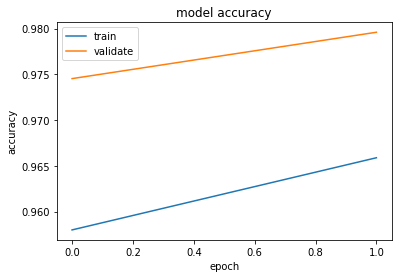

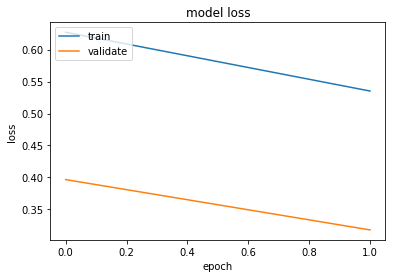

In [36]:
plot_history(history)
#nb: plot when only one epoch produces a blank chart.

In [37]:
#history.history['acc']
#history.history['val_acc']

In [38]:
model.evaluate(val_data, val_labels)

7500/7500 [==============================] - 185s   


[0.31788790485896001, 0.97960000000000003]

In [39]:
model.metrics_names

['loss', 'acc']

In [40]:
preds = model.predict_classes(val_data, batch_size=batch_size)
probs = model.predict_proba(val_data, batch_size=batch_size)[:,0]


7500/7500 [==============================] - 182s   


In [41]:
print ("preds:", type(preds), preds.shape)
print ("probs:", type(probs), probs.shape)

('preds:', <type 'numpy.ndarray'>, (7500,))
('probs:', <type 'numpy.ndarray'>, (7500,))


In [42]:
type(val_batches)

keras.preprocessing.image.NumpyArrayIterator

In [43]:
#val_batches is NumpyArrayIterator due to last assignment : val_batches = gen.flow(blah....)
#val_filenames = val_batches.filenames
#can only use val_batches.filenames when val_batches is type keras.preprocessing.image.DirectoryIterator 
#ie: need val_batches = get_batches(blah....) 
#print (type(val_filenames))

In [44]:
print "probs:", probs[:10]
print "preds:", preds[:10]

probs: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
preds: [0 0 0 0 0 0 0 0 0 0]


In [45]:
cm = confusion_matrix(val_classes, preds)

[[3702   48]
 [ 105 3645]]


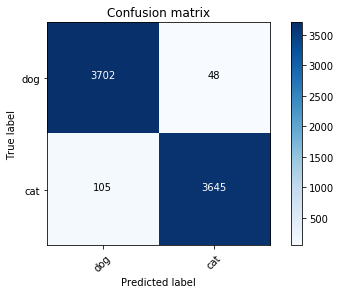

In [46]:
plot_confusion_matrix(cm, {'cat':0, 'dog':1})

In [47]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [48]:
showLayersInfo(model)

('Number of layers : ', 38)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [49]:
layers = model.layers
# Get the index of the first dense layer...
first_dense_idx = [index for index,layer in enumerate(layers) if type(layer) is Dense][0]
print (type(first_dense_idx), first_dense_idx)


(<type 'int'>, 33)


In [50]:
# ...and set this and all subsequent layers to trainable
for layer in layers[first_dense_idx:]: 
    layer.trainable=True

In [51]:
type(K)
#NB from utils.py: from keras import backend as K

module

In [52]:
K.set_value(opt.lr, 0.01)
#https://keras.io/backend/
#keras.backend.set_value(x, value)
#https://www.tensorflow.org/api_docs/python/tf/keras/backend/set_value


In [53]:
history = fit_model(model, trn_batches, val_batches, 3)

Epoch 1/3
17500/17500 [==============================] - 607s - loss: 0.4427 - acc: 0.9719 - val_loss: 0.2942 - val_acc: 0.9813
Epoch 2/3
17500/17500 [==============================] - 607s - loss: 0.4213 - acc: 0.9734 - val_loss: 0.2815 - val_acc: 0.9823
Epoch 3/3
17500/17500 [==============================] - 607s - loss: 0.4221 - acc: 0.9731 - val_loss: 0.3106 - val_acc: 0.9804


['acc', 'loss', 'val_acc', 'val_loss']


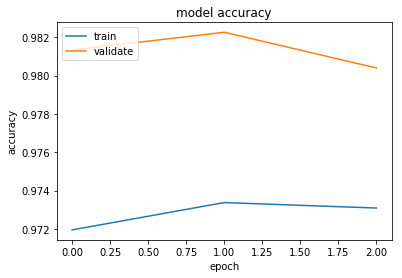

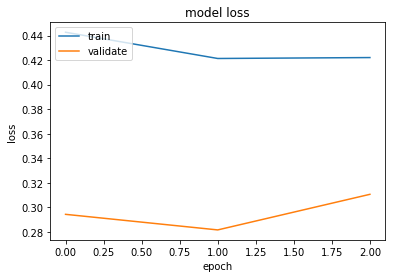

In [54]:
plot_history(history)
#nb: plot when only one epoch produces a blank chart.

In [55]:
model.save_weights(MODEL_PATH+'finetune2'+s_or_p+'.h5')

In [56]:
showLayersInfo(model)

('Number of layers : ', 38)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [57]:
#previously we set the layers from first dense layer (#33) to be trainable, set a learning rate, trained.
#now making more layers trainable from 12th layer. (Convolution2D layer @ #13)
for layer in layers[12:]: 
    layer.trainable=True

In [58]:
showLayersInfo(model)

('Number of layers : ', 38)
0 <class 'keras.layers.core.Lambda'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 224, 224) 

1 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 3, 224, 224) , output: (None, 3, 226, 226) 

2 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 3, 226, 226) , output: (None, 64, 224, 224) 

3 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 226, 226) 

4 <class 'keras.layers.convolutional.Convolution2D'> , trainable: False
input: (None, 64, 226, 226) , output: (None, 64, 224, 224) 

5 <class 'keras.layers.pooling.MaxPooling2D'> , trainable: False
input: (None, 64, 224, 224) , output: (None, 64, 112, 112) 

6 <class 'keras.layers.convolutional.ZeroPadding2D'> , trainable: False
input: (None, 64, 112, 112) , output: (None, 64, 114, 114) 

7 <class 'keras.layers.convolutional.Convolution2D'> , trainable: Fal

In [59]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [60]:
#nb: previous learning rate was 0.01
K.set_value(opt.lr, 0.001)

In [61]:
history = fit_model(model, trn_batches, val_batches, 4)

Epoch 1/4
17500/17500 [==============================] - 607s - loss: 0.4490 - acc: 0.9718 - val_loss: 0.3018 - val_acc: 0.9809
Epoch 2/4
17500/17500 [==============================] - 607s - loss: 0.4432 - acc: 0.9718 - val_loss: 0.2981 - val_acc: 0.9812
Epoch 3/4
17500/17500 [==============================] - 606s - loss: 0.4184 - acc: 0.9734 - val_loss: 0.2921 - val_acc: 0.9813
Epoch 4/4
17500/17500 [==============================] - 607s - loss: 0.4115 - acc: 0.9739 - val_loss: 0.2902 - val_acc: 0.9813


['acc', 'loss', 'val_acc', 'val_loss']


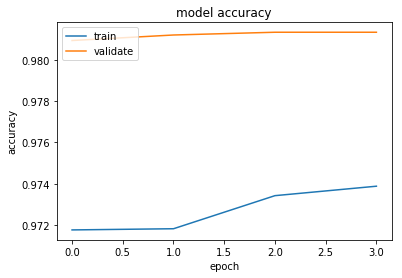

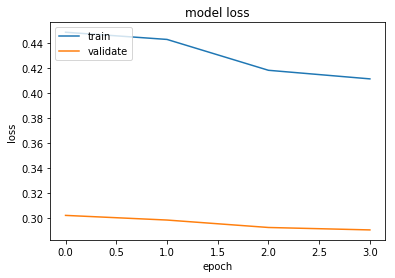

In [62]:
plot_history(history)

In [63]:
model.save_weights(MODEL_PATH+'finetune3'+s_or_p+'.h5')#this model is imported into next stage

In [64]:
#model.load_weights(model_path+'finetune2.h5')

In [65]:
model.evaluate_generator(get_batches(WORKING_VALID, gen, False, batch_size*2), val_batches.n)

Found 7500 images belonging to 2 classes.


[0.29015673973911399, 0.98133333333333328]